In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.linear_model 
import sklearn.ensemble 

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore') 

from matplotlib import rcParams
rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_columns', None)
sns.set(rc = {'figure.figsize':(15,3)})
sns.set(font_scale=0.8)

%matplotlib inline

In [3]:
print('pandas Version :', pd.__version__)
print('numpy Version :', np.__version__)
print('sklearn Version :', sklearn.__version__)
print('seaborn Version :', sns.__version__)

pandas Version : 2.0.2
numpy Version : 1.24.3
sklearn Version : 1.0.2
seaborn Version : 0.12.2


In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sample_submission.csv')

In [6]:
def fn_get_feature_v3(df, idx=2) :    
    idx = 2 - idx
    if idx > 7 :
        idx = 6
    
    # 파생 변수
    df = df.copy()
    df['새순mean'] = df.iloc[:,6-idx:95-idx].mean(axis=1)
    df['새순std'] = df.iloc[:,6-idx:95-idx].std(axis=1)
    df['새순min'] = df.iloc[:,6-idx:95-idx].min(axis=1)
    df['새순max'] = df.iloc[:,6-idx:95-idx].max(axis=1)
    df['새순gap'] = df.iloc[:,94-idx] - df.iloc[:,6-idx]
    
    df['엽록소mean'] = df.iloc[:,95-idx:184-idx].mean(axis=1)
    df['엽록소std'] = df.iloc[:,95-idx:184-idx].std(axis=1)
    df['엽록소min'] = df.iloc[:,95-idx:184-idx].min(axis=1)
    df['엽록소max'] = df.iloc[:,95-idx:184-idx].max(axis=1)
    df['엽록소gap'] = df.iloc[:,183-idx] - df.iloc[:,95-idx]  
    

    df_v1 = df.iloc[:,1-idx:6-idx] # 시계열 데이터 제외한 학습 데이터
    df_v2 = df.iloc[:,1-idx:184-idx] # 원본 데이터
    df_v3 = pd.concat([df.iloc[:,1-idx:6-idx], df.iloc[:,184-idx:]], axis=1) # 파생변수 포함한 학습 데이터 (세순 및 엽록소 시계열 데이터 제외)
    df_v4 = df.iloc[:,1-idx:] # 파생변수까지 모두 포함한 학습 데이터
    df_v5 = pd.concat([df.iloc[:,1-idx:6-idx], df.iloc[:,184-idx:189-idx]], axis=1) # 시계열 데이터 제외, 새순 관련 파생병수만 포함된 학습 데이터
    df_v6 = df.iloc[:,1-idx:189-idx] # 원본데이터에 새순 관련 파생변수만 포함한 학습 데이터
    
    df_v7 = pd.concat([df.iloc[:,1-idx:95-idx], df.iloc[:,184-idx:189-idx]], axis=1) # 수고,수관폭 및 세순관련 시계열 데이터 + 파생변수만 포함된 학습 데이터
    df_v8 = pd.concat([df.iloc[:,1-idx:95-idx], df.iloc[:,184-idx:]], axis=1) # 수고,수관폭, 세순관련 시계열 데이터, 세순 관련 파생변수, 엽록소 관련 파생변수가 포함된 학습 데이터
    
    df_v9 = pd.concat([df.iloc[:,1-idx], df.iloc[:,6-idx:95-idx]], axis=1)
    df_v9 = pd.concat([df_v9, df.iloc[:,184-idx:189-idx]], axis=1) # 세순관련 시계열 데이터 및 세순 관련 파생변수만 포한된 학습데이터
    

    return df_v1, df_v2, df_v3, df_v4, df_v5, df_v6, df_v7, df_v8, df_v9

In [7]:
def nmae_score(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [8]:
def fn_exec_model_RandomForestRegressor(df_train, n_estimators=300, max_depth=5, test_size=0.3) :
    
    x = df_train
    if df_train.columns.isin(['ID']).any() :
        x = df_train.drop(['ID'], axis=1)    
    if df_train.columns.isin(['착과량(int)']).any() :
        x = df_train.drop(['착과량(int)'], axis=1)
        
    y = df_train['착과량(int)']
    #display(x.head(2))

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=10)
    #print("Train Shape : ", x.shape, y.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape)

    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)    
    
    model_rfr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=10)
    model_rfr.fit(x_train_scaled, y_train)
    pred_rfr = model_rfr.predict(x_test_scaled)
    score_nmae = round(nmae_score(y_test, pred_rfr),5) # nmae 계산
    #print(f"RandomForestRegressor : {n_estimators} - nmae : {score_nmae} ")
    
    return score_nmae

In [9]:
def fn_exec_model_predict(df_train, df_test, n_estimators=300, max_depth=5) :

    # ***************************** Train ********************************
    # Make the dataset for train
    x_train = df_train
    y_train = df_train['착과량(int)']
    
    if df_train.columns.isin(['ID']).any() :
        x_train = df_train.drop(['ID'], axis=1)    
    if df_train.columns.isin(['착과량(int)']).any() :
        x_train = df_train.drop(['착과량(int)'], axis=1)
    
    # Scale
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    
    # Train
    model_rfr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=10)
    model_rfr.fit(x_train_scaled, y_train)
    

    # ***************************** Predict ******************************    
    # Make the dataset for test    
    x_test = df_test
    if df_test.columns.isin(['ID']).any() :
        x_test = df_test.drop(['ID'], axis=1)    
    if df_test.columns.isin(['착과량(int)']).any() :
        x_test = df_test.drop(['착과량(int)'], axis=1)
    
    # Scale
    x_test_scaled = scaler.transform(x_test)    

    # Predict
    pred_rfr = model_rfr.predict(x_test_scaled)

    #display(pred_rfr)
    return pred_rfr

In [10]:
df_train_v1, df_train_v2, df_train_v3, df_train_v4, df_train_v5, df_train_v6, df_train_v7, df_train_v8, df_train_v9= fn_get_feature_v3(df_train, idx=2)
df_train_v2.head(2)

,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,2022-09-06 새순,2022-09-07 새순,2022-09-08 새순,2022-09-09 새순,2022-09-10 새순,2022-09-11 새순,2022-09-12 새순,2022-09-13 새순,2022-09-14 새순,2022-09-15 새순,2022-09-16 새순,2022-09-17 새순,2022-09-18 새순,2022-09-19 새순,2022-09-20 새순,2022-09-21 새순,2022-09-22 새순,2022-09-23 새순,2022-09-24 새순,2022-09-25 새순,2022-09-26 새순,2022-09-27 새순,2022-09-28 새순,2022-09-29 새순,2022-09-30 새순,2022-10-01 새순,2022-10-02 새순,2022-10-03 새순,2022-10-04 새순,2022-10-05 새순,2022-10-06 새순,2022-10-07 새순,2022-10-08 새순,2022-10-09 새순,2022-10-10 새순,2022-10-11 새순,2022-10-12 새순,2022-10-13 새순,2022-10-14 새순,2022-10-15 새순,2022-10-16 새순,2022-10-17 새순,2022-10-18 새순,2022-10-19 새순,2022-10-20 새순,2022-10-21 새순,2022-10-22 새순,2022-10-23 새순,2022-10-24 새순,2022-10-25 새순,2022-10-26 새순,2022-10-27 새순,2022-10-28 새순,2022-10-29 새순,2022-10-30 새순,2022-10-31 새순,2022-11-01 새순,2022-11-02 새순,2022-11-03 새순,2022-11-04 새순,2022-11-05 새순,2022-11-06 새순,2022-11-07 새순,2022-11-08 새순,2022-11-09 새순,2022-11-10 새순,2022-11-11 새순,2022-11-12 새순,2022-11-13 새순,2022-11-14 새순,2022-11-15 새순,2022-11-16 새순,2022-11-17 새순,2022-11-18 새순,2022-11-19 새순,2022-11-20 새순,2022-11-21 새순,2022-11-22 새순,2022-11-23 새순,2022-11-24 새순,2022-11-25 새순,2022-11-26 새순,2022-11-27 새순,2022-11-28 새순,2022-09-01 엽록소,2022-09-02 엽록소,2022-09-03 엽록소,2022-09-04 엽록소,2022-09-05 엽록소,2022-09-06 엽록소,2022-09-07 엽록소,2022-09-08 엽록소,2022-09-09 엽록소,2022-09-10 엽록소,2022-09-11 엽록소,2022-09-12 엽록소,2022-09-13 엽록소,2022-09-14 엽록소,2022-09-15 엽록소,2022-09-16 엽록소,2022-09-17 엽록소,2022-09-18 엽록소,2022-09-19 엽록소,2022-09-20 엽록소,2022-09-21 엽록소,2022-09-22 엽록소,2022-09-23 엽록소,2022-09-24 엽록소,2022-09-25 엽록소,2022-09-26 엽록소,2022-09-27 엽록소,2022-09-28 엽록소,2022-09-29 엽록소,2022-09-30 엽록소,2022-10-01 엽록소,2022-10-02 엽록소,2022-10-03 엽록소,2022-10-04 엽록소,2022-10-05 엽록소,2022-10-06 엽록소,2022-10-07 엽록소,2022-10-08 엽록소,2022-10-09 엽록소,2022-10-10 엽록소,2022-10-11 엽록소,2022-10-12 엽록소,2022-10-13 엽록소,2022-10-14 엽록소,2022-10-15 엽록소,2022-10-16 엽록소,2022-10-17 엽록소,2022-10-18 엽록소,2022-10-19 엽록소,2022-10-20 엽록소,2022-10-21 엽록소,2022-10-22 엽록소,2022-10-23 엽록소,2022-10-24 엽록소,2022-10-25 엽록소,2022-10-26 엽록소,2022-10-27 엽록소,2022-10-28 엽록소,2022-10-29 엽록소,2022-10-30 엽록소,2022-10-31 엽록소,2022-11-01 엽록소,2022-11-02 엽록소,2022-11-03 엽록소,2022-11-04 엽록소,2022-11-05 엽록소,2022-11-06 엽록소,2022-11-07 엽록소,2022-11-08 엽록소,2022-11-09 엽록소,2022-11-10 엽록소,2022-11-11 엽록소,2022-11-12 엽록소,2022-11-13 엽록소,2022-11-14 엽록소,2022-11-15 엽록소,2022-11-16 엽록소,2022-11-17 엽록소,2022-11-18 엽록소,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,692,275.0,287.0,292.0,289.5,2.8,2.8,2.7,2.7,2.7,2.7,2.6,2.6,2.6,2.6,2.5,2.5,2.5,2.5,2.4,2.4,2.4,2.4,2.3,2.3,2.3,2.3,2.2,2.2,2.2,2.2,2.1,2.1,2.1,2.1,2.0,2.0,2.0,2.0,1.9,1.9,1.9,1.9,1.8,1.8,1.8,1.8,1.7,1.7,1.7,1.7,1.6,1.6,1.6,1.6,1.5,1.5,1.5,1.5,1.4,1.4,1.4,1.4,1.3,1.3,1.3,1.2,1.2,1.2,1.2,1.2,1.1,1.1,1.1,1.1,1.0,1.0,1.0,1.0,1.0,0.9,0.9,0.9,0.9,0.9,0.8,0.8,0.8,0.7,0.7,0.7,0.7,0.7,0.6,78.336504,78.243462,78.166501,78.127526,78.058021,77.915689,77.861660,77.746645,77.592138,77.572477,77.382045,77.211789,77.151051,77.063069,76.905981,76.868475,76.732897,76.669280,76.662585,76.519409,76.349661,76.186091,76.040207,75.999415,75.990592,75.953731,75.829564,75.798673,75.621243,75.427005,75.266187,75.226094,75.162319,75.079444,75.013855,74.935697,74.842749,74.836657,74.816928,74.788574,74.690358,74.504942,74.394908,74.351704,74.166346,74.020254,73.835142,73.766164,73.755269,73.627395,73.465457,73.395076,73.311405,73.243028,73.087409,73.081651,73.023755,72.987263,72.977606,72.838462,72.645386,72.512869,72.445908,72.370097,72.301180,72.228374,72.207746,72.068354,71.987663,71.869466,71.852923,71.690854,71.576402,71.384018,71.301893,71.234817,71.076903,70.996113,70.985843,70.978249,70.876794,70.705253,70.559603,70.427356,70.340491,70.29383,70.262422,70.169841,70.043251
1,534,293.0,284.0,336.0,310.0,3.3,3.3,3.3,3.2,3.2,3.1,3.1,3.1,3.0,3.0,3.0,2.9,2.9,2.9,2.9,2.8,2.8,2.8,

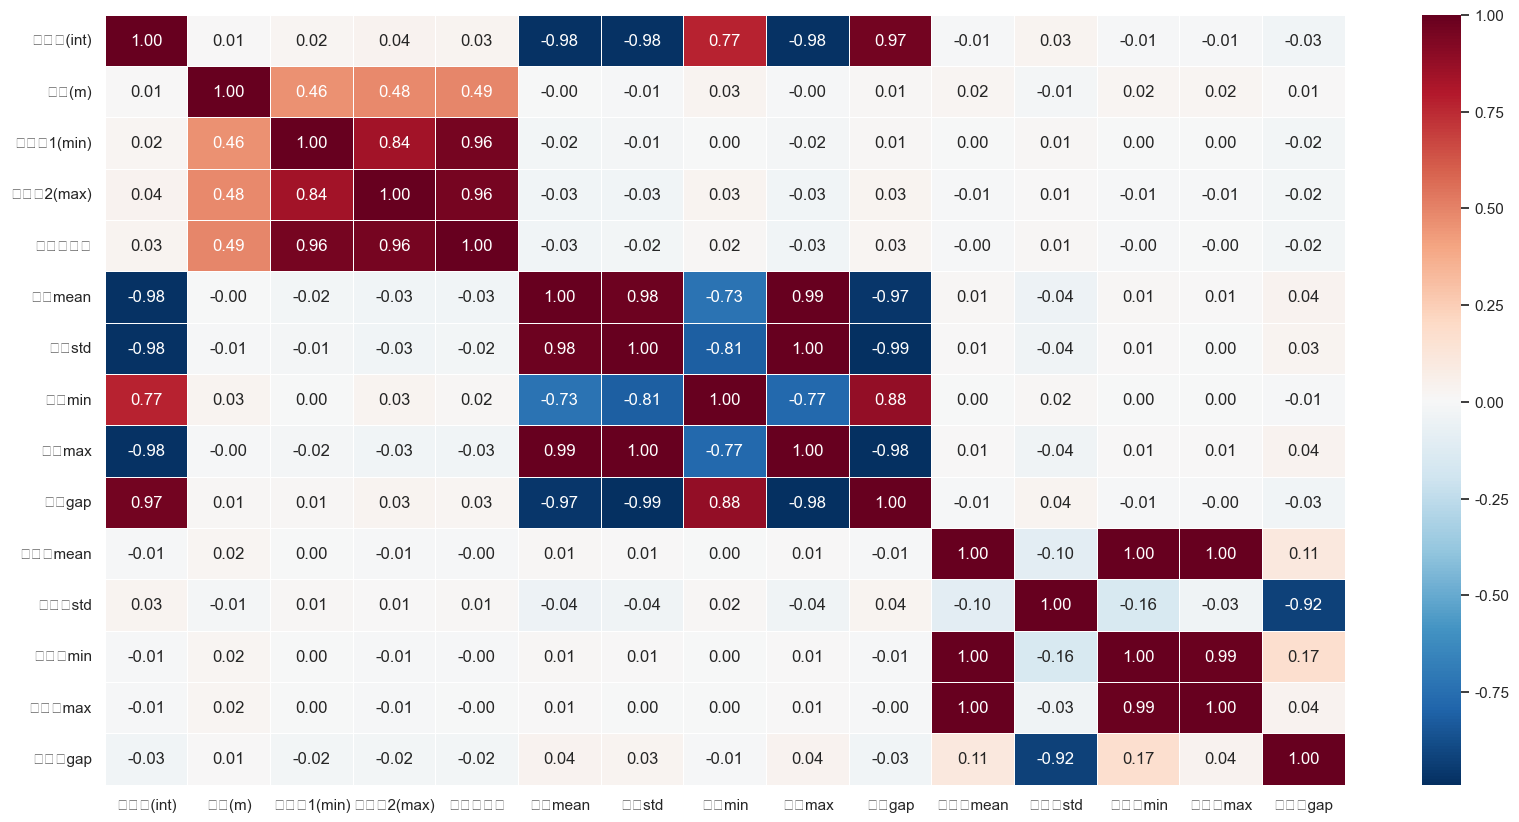

In [11]:
# EDA 수행
sns.set(rc = {'figure.figsize':(20,10)})
sns.heatmap(data = df_train_v3.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='RdBu_r')
plt.show()

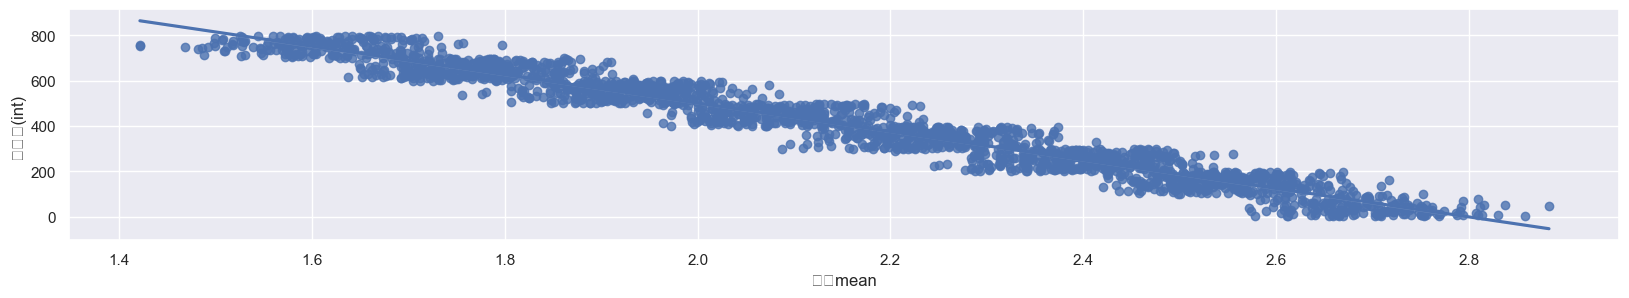

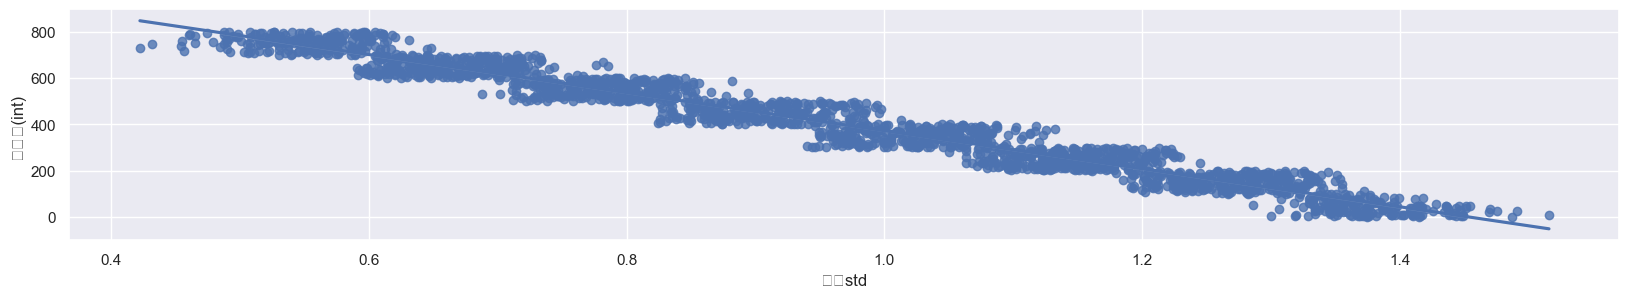

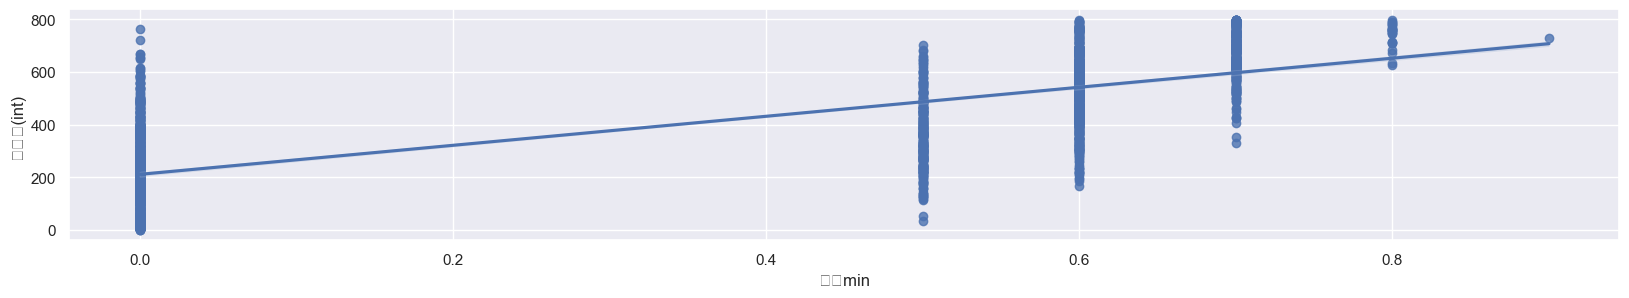

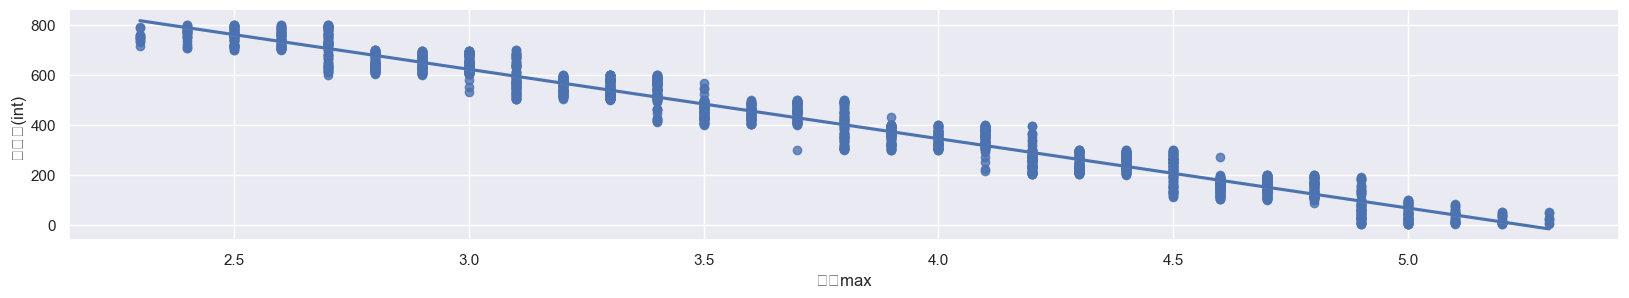

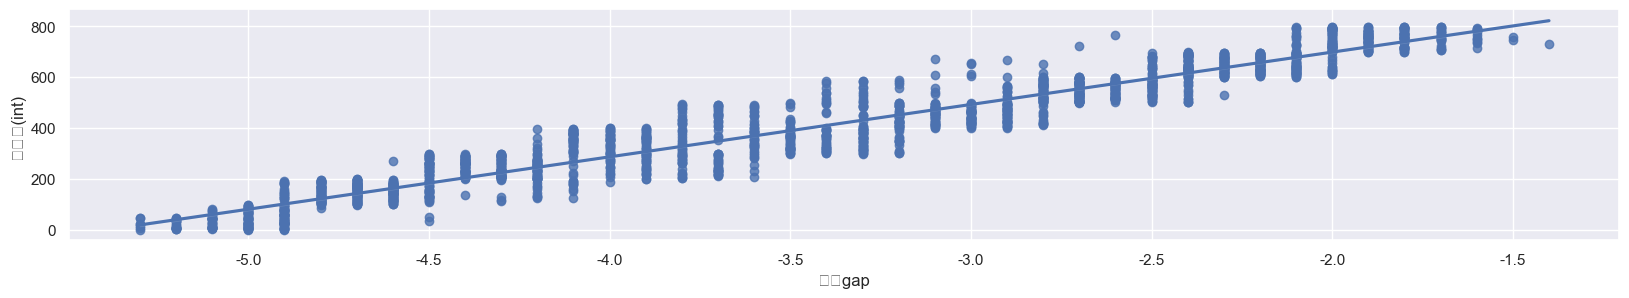

In [12]:
sns.set(rc = {'figure.figsize':(20,3)})
sns.regplot(x='새순mean', y='착과량(int)', data=df_train_v3, dropna=True)
plt.show()
sns.regplot(x='새순std', y='착과량(int)', data=df_train_v3, dropna=True)
plt.show()
sns.regplot(x='새순min', y='착과량(int)', data=df_train_v3, dropna=True)
plt.show()
sns.regplot(x='새순max', y='착과량(int)', data=df_train_v3, dropna=True)
plt.show()
sns.regplot(x='새순gap', y='착과량(int)', data=df_train_v3, dropna=True)
plt.show()

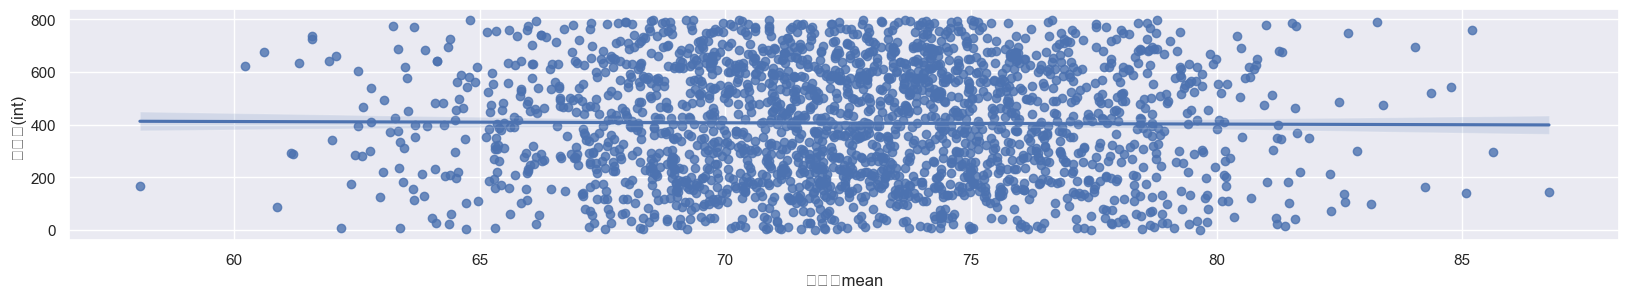

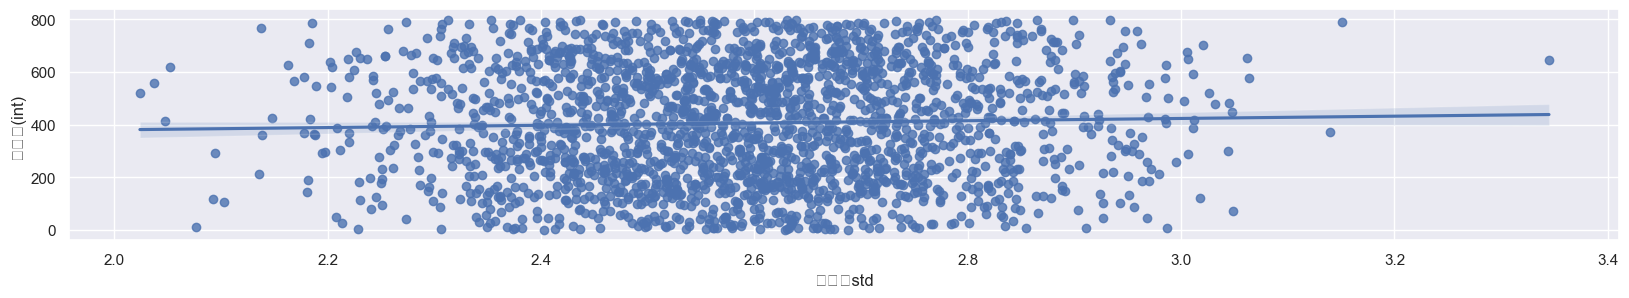

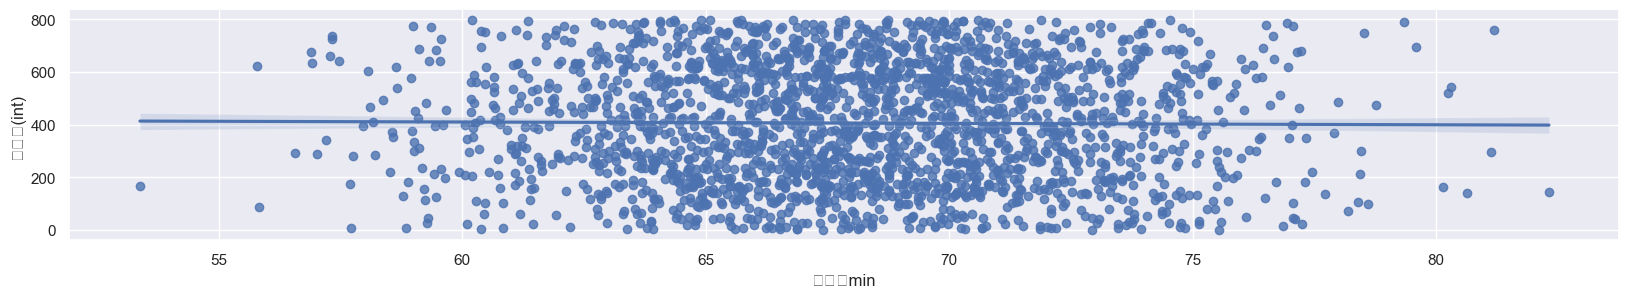

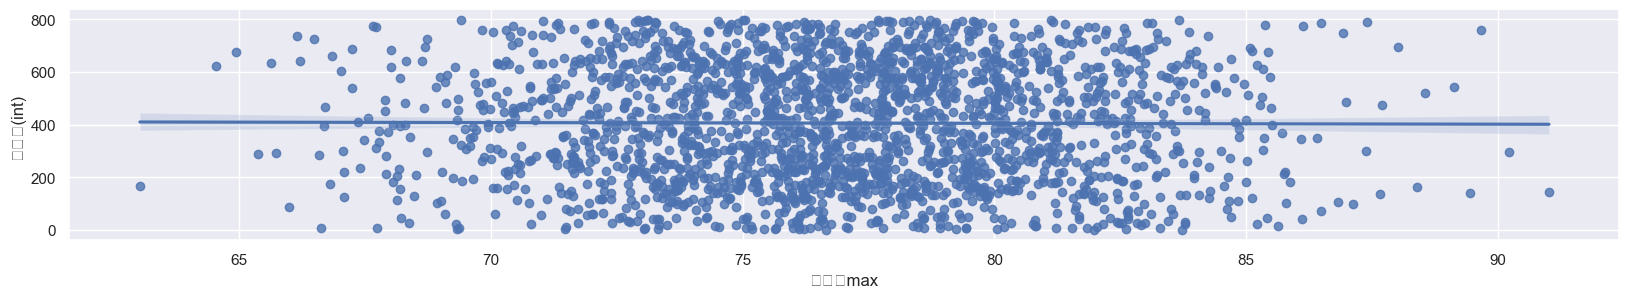

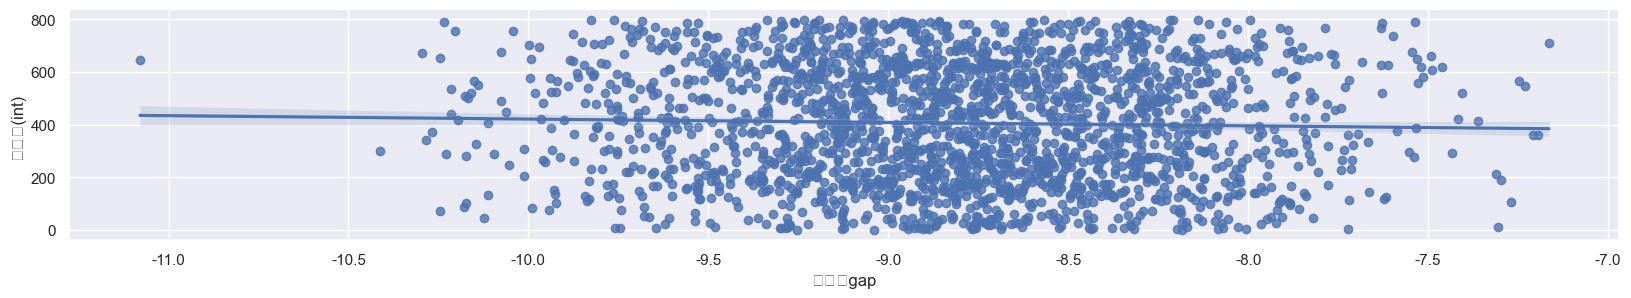

In [13]:
sns.set(rc = {'figure.figsize':(20,3)})
sns.regplot(x='엽록소mean', y='착과량(int)', data=df_train_v3, dropna=True)
plt.show()
sns.regplot(x='엽록소std', y='착과량(int)', data=df_train_v3, dropna=True)
plt.show()
sns.regplot(x='엽록소min', y='착과량(int)', data=df_train_v3, dropna=True)
plt.show()
sns.regplot(x='엽록소max', y='착과량(int)', data=df_train_v3, dropna=True)
plt.show()
sns.regplot(x='엽록소gap', y='착과량(int)', data=df_train_v3, dropna=True)
plt.show()

<Axes: >

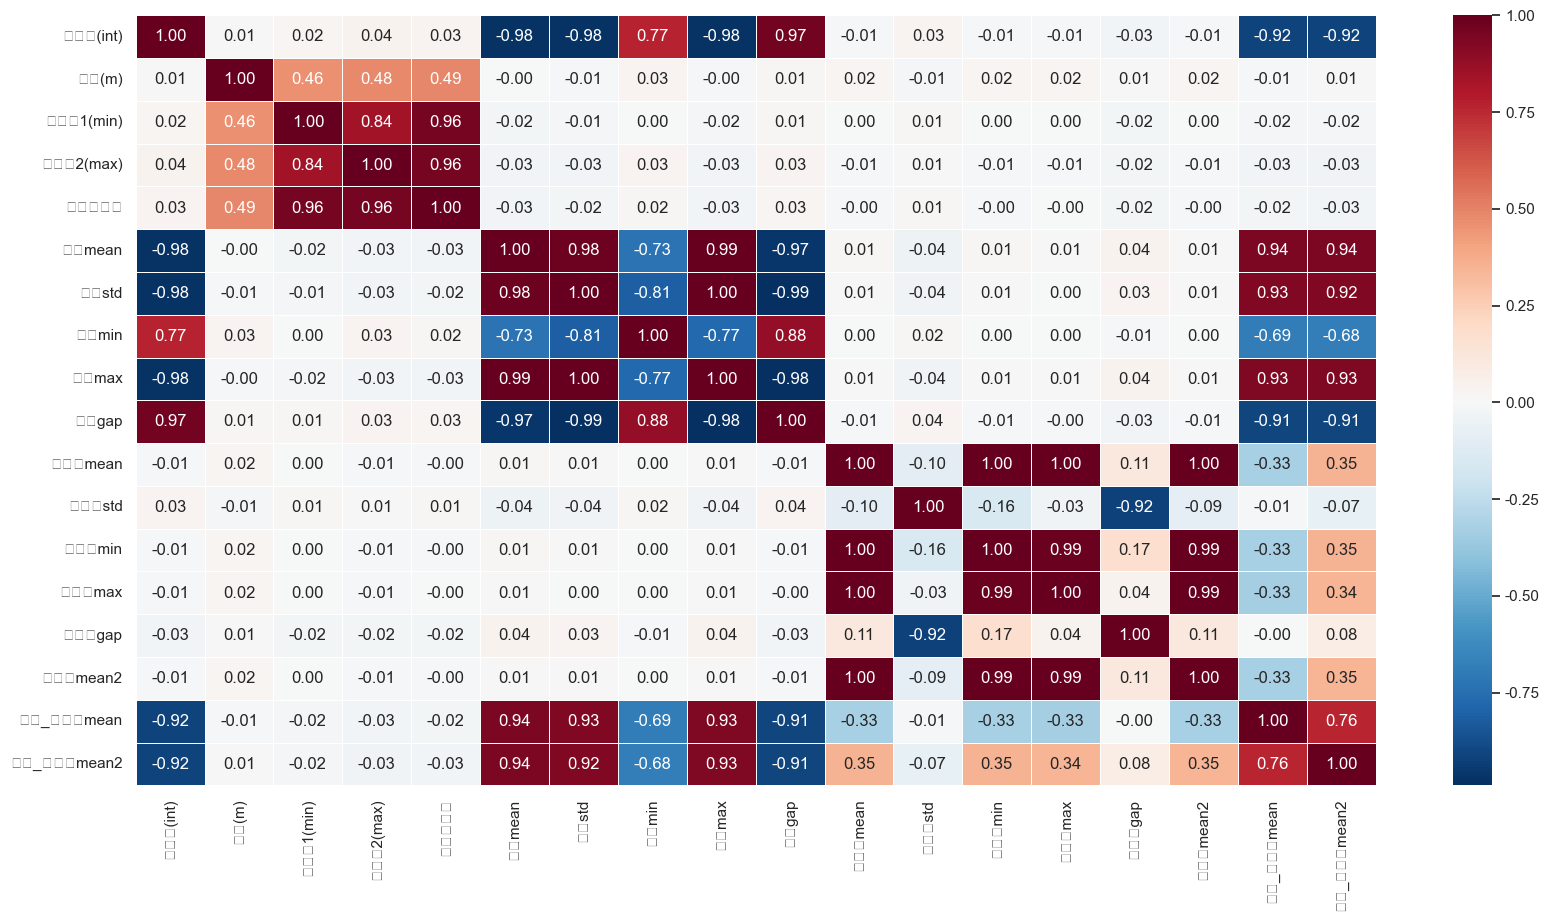

In [14]:
df_train_v3_1 = df_train_v3.copy()
df_train_v3_1['엽록소mean2'] = round(df_train_v3_1['엽록소mean']/100,2)*100
df_train_v3_1['새순_엽록소mean'] = round(df_train_v3_1['새순mean']/df_train_v3_1['엽록소mean'],7)*100
df_train_v3_1['새순_엽록소mean2'] = round(df_train_v3_1['새순mean']*df_train_v3_1['엽록소mean']/1000,7)*100
df_train_v3_1.head(2)

sns.set(rc = {'figure.figsize':(20,10)})
sns.heatmap(data = df_train_v3_1.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='RdBu_r')

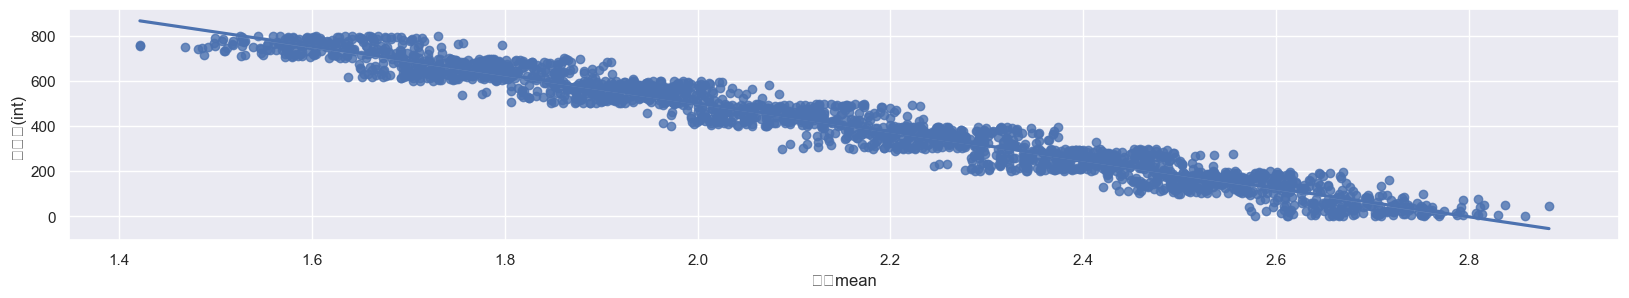

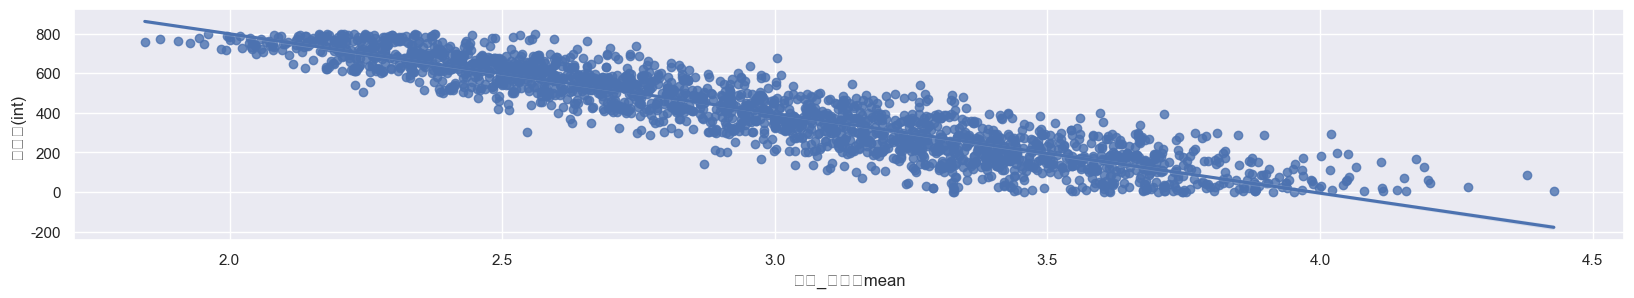

In [15]:
sns.set(rc = {'figure.figsize':(20,3)})
sns.regplot(x='새순mean', y='착과량(int)', data=df_train_v3_1.iloc[:])
plt.show()
sns.regplot(x='새순_엽록소mean', y='착과량(int)', data=df_train_v3_1.iloc[:])
plt.show()

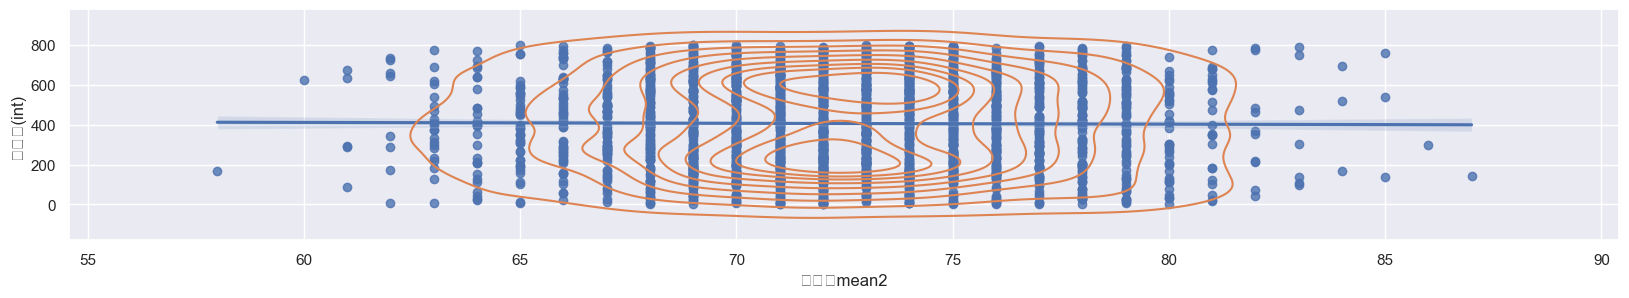

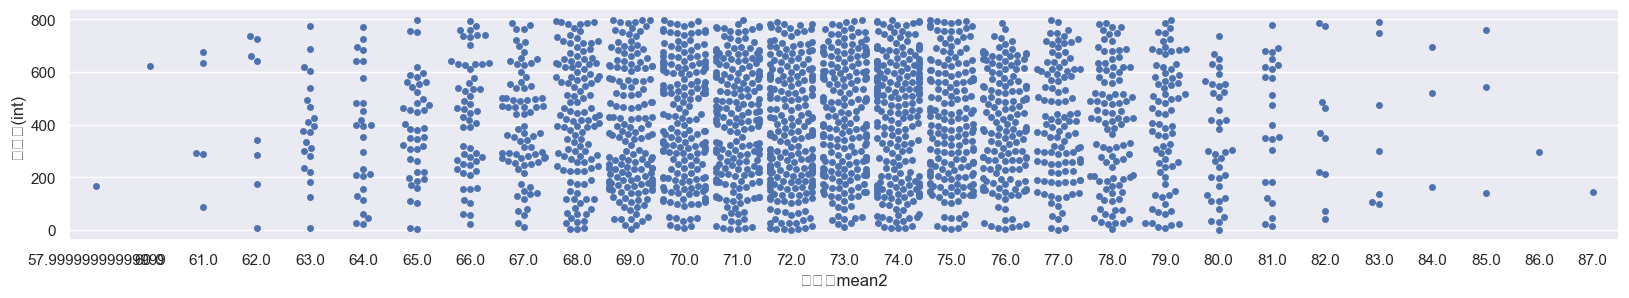

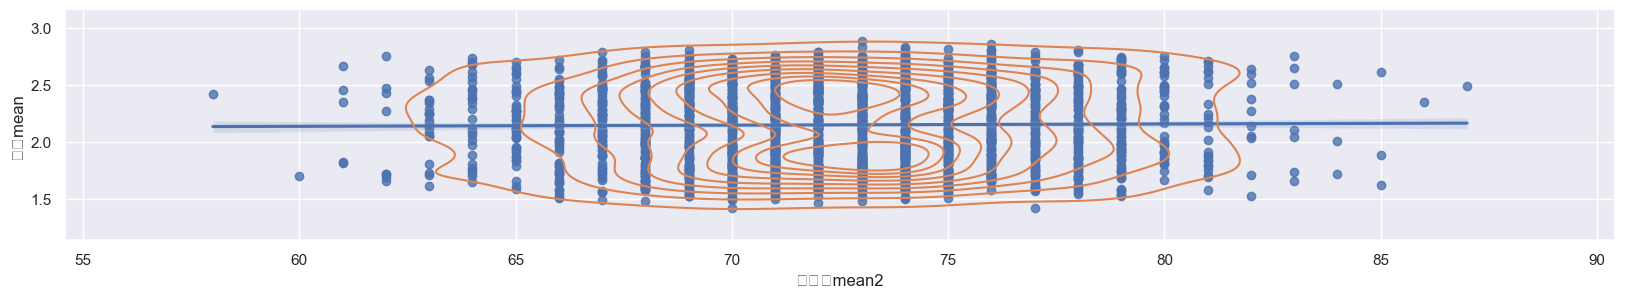

In [16]:
sns.regplot(x='엽록소mean2', y='착과량(int)', data=df_train_v3_1.iloc[:])
sns.kdeplot(x='엽록소mean2', y='착과량(int)', data=df_train_v3_1.iloc[:])
plt.show()

sns.swarmplot(x='엽록소mean2', y='착과량(int)', data=df_train_v3_1.iloc[:])
plt.show()

sns.regplot(x='엽록소mean2', y='새순mean', data=df_train_v3_1.iloc[:])
sns.kdeplot(x='엽록소mean2', y='새순mean', data=df_train_v3_1.iloc[:])
plt.show()

##### 결과
###### 새순과는 강한 음의 관계를 가지고 엽록소와는 큰 상관관계가 없는 것으로 보이며, 수고,수관폭등도 착과량과 큰 상관관계를 보이고 있지 않아 학습시 제외하는 것으로 함
###### 엽록소가 포함된 파생변수를 생성하였지만, 상관관계를 오히려 방해하는 것으로 판단됨
###### 새순 관련된 시계열 정보와 통계 정보만을 이용하여 학습 진행

#### 모델 생성 및 평가

In [17]:

# best_score = 1

# for n_estimators in range(100,1100,100) :
#     for max_depth in range(1,11) :
#         score = fn_exec_model_RandomForestRegressor(df_train_v4, n_estimators=n_estimators, max_depth=max_depth)

#         # rmse가 best_score보다 낮으면, 매개변수와 함께 기록
#         if score < best_score :
#             best_score = score
#             best_parameters = {'n_estimators':n_estimators, 'max_depth':max_depth, 'df_train':"df_train_v4"}
#             print(f"{n_estimators}, {max_depth} : {score} <----- best Score")
#         else :
#             print(f"{n_estimators}, {max_depth} : {score}")
            
# print('best rmse score(in cross_val): ', best_score)
# print('최적의 매개변수: ', best_parameters)    

In [18]:
# 하이퍼 파레머터 선정 결과
# 다양한 모델들에 대해서 진행하였으며, RandomForestRegressor가 가장 좋은 결과를 가졌음
# 또한 n_estimators = 400 ~ 500, max_depth = 5 일떄가 좋은 학습 결과를 가짐
print("다양한 모델들에 대해서 진행하였으며, RandomForestRegressor가 가장 좋은 결과를 가졌음")
print("n_estimators = 400 ~ 500, max_depth = 5 일떄가 좋은 학습 결과를 가짐")

다양한 모델들에 대해서 진행하였으며, RandomForestRegressor가 가장 좋은 결과를 가졌음
n_estimators = 400 ~ 500, max_depth = 5 일떄가 좋은 학습 결과를 가짐


In [19]:
print("사용한 학습데이터 버전 : df_train_v9 - 새순 관련 시계열과 파생변수만 사용")
n_estimators = 500
max_depth = 5

print("모델 : RandomForestRegressor")
print("하이퍼파라메타 : n_estimators=500, max_depth=5")
print("학습데이터 검증을 위한 테스트셋 사이즈 30%")
score = fn_exec_model_RandomForestRegressor(df_train_v9, n_estimators=n_estimators, max_depth=max_depth)
print(f"NMAE : {score}")

사용한 학습데이터 버전 : df_train_v9 - 새순 관련 시계열과 파생변수만 사용
모델 : RandomForestRegressor
하이퍼파라메타 : n_estimators=500, max_depth=5
학습데이터 검증을 위한 테스트셋 사이즈 30%
NMAE : 0.07342


In [20]:
# The best result
df_test_v1, df_test_v2, df_test_v3, df_test_v4, df_test_v5, df_test_v6, df_test_v7, df_test_v8, df_test_v9 = fn_get_feature_v3(df_test, idx=1)
pred = fn_exec_model_predict(df_train_v9, df_test_v9, n_estimators=n_estimators, max_depth=max_depth)
df_submission['착과량(int)'] = pred
df_submission.to_csv('./submit_model_rfr_type9_final.csv', index=False)
display(df_submission)

,ID,착과량(int)
0,TEST_0000,247.167712
1,TEST_0001,753.752185
2,TEST_0002,151.699445
3,TEST_0003,448.403894
4,TEST_0004,685.501592
...,...,...
2203,TEST_2203,754.207627
2204,TEST_2204,337.601650
2205,TEST_2205,358.527152
2206,TEST_2206,243.299788


In [21]:
# The second result
df_test_v1, df_test_v2, df_test_v3, df_test_v4, df_test_v5, df_test_v6, df_test_v7, df_test_v8, df_test_v9 = fn_get_feature_v3(df_test, idx=1)
pred = fn_exec_model_predict(df_train_v7, df_test_v7, n_estimators=n_estimators, max_depth=max_depth)
df_submission['착과량(int)'] = pred
df_submission.to_csv('./submit_model_rfr_type7_final.csv', index=False)
display(df_submission)

,ID,착과량(int)
0,TEST_0000,247.321093
1,TEST_0001,754.597575
2,TEST_0002,151.703672
3,TEST_0003,449.015865
4,TEST_0004,683.607004
...,...,...
2203,TEST_2203,754.573179
2204,TEST_2204,340.213524
2205,TEST_2205,355.275867
2206,TEST_2206,244.066967
